In [1]:
import numpy as np
import yfinance as yf
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
stocks = ['MSFT','AAPL', 'AMZN', 'GOOG', 'TSLA', 'JPM', 'NFLX']
etf = ['DIA','IWM','SPY'] 

n = len(stocks)
weight = 1/n

In [3]:
data = yf.download(stocks + etf, period = '10y')['Adj Close']

[*********************100%***********************]  10 of 10 completed


In [33]:
data = yf.download(stocks+etf, period='11y')['Adj Close']

portfolio = (data[stocks].pct_change(252) * weight).sum(axis=1)
portfolio = portfolio.rename("Portfolio")

returns = pd.concat([data.pct_change(252), portfolio], axis = 1)

cov_matrix = returns[252:].cov(ddof=0)
corr_matrix = returns[252:].corr(method="pearson")

[*********************100%***********************]  10 of 10 completed


In [34]:
def drawdown(stock_close): 
    weekly_data = stock_close.resample('7D').ffill()
    rolling_max = weekly_data.rolling(window=52,min_periods=1).max()
   
    return (weekly_data - rolling_max)/rolling_max

def beta(stock, index):
    return cov_matrix[stock][index]/cov_matrix[index][index]

In [36]:
assets = pd.DataFrame(index = stocks)

assets['PortfolioWeight'] = weight
assets['AnnualizeVolatility'] = data[-63:].std()*(252**0.5)
assets['BetaAgainstSPY'] = [beta(stock , 'SPY') for stock in stocks]
assets['BetaAgainstIWM'] = [beta(stock , 'IWM') for stock in stocks]
assets['BetaAgainstDIA'] = [beta(stock , 'DIA') for stock in stocks]
assets['AverageWeeklyDrawdown'] = [(drawdown(data[stock])).mean() for stock in stocks]
assets['MaximumWeeklyDrawdown'] = [(drawdown(data[stock])).min() for stock in stocks]
assets['TotalReturn'] = (data.iloc[-1] - data.iloc[252])/data.iloc[252]
assets['AnnualizedTotalReturn'] = ((data.iloc[-1]/data.iloc[252])**(1/10)) - 1

assets

,PortfolioWeight,AnnualizeVolatility,BetaAgainstSPY,BetaAgainstIWM,BetaAgainstDIA,AverageWeeklyDrawdown,MaximumWeeklyDrawdown,TotalReturn,AnnualizedTotalReturn
MSFT,0.142857,369.582507,1.084597,0.451084,0.938961,-0.051389,-0.330242,10.995151,0.282037
AAPL,0.142857,149.892235,1.514246,0.695571,1.204167,-0.082765,-0.352711,9.896828,0.269784
AMZN,0.142857,153.831329,0.850433,0.540668,0.817080,-0.101409,-0.502931,6.687876,0.226255
GOOG,0.142857,73.177041,1.579889,0.859183,1.425969,-0.072671,-0.406579,4.155964,0.178232
TSLA,0.142857,275.572388,5.868459,3.308056,3.135813,-0.183278,-0.692069,24.029720,0.379894
JPM,0.142857,134.958795,1.484425,0.959917,1.745612,-0.074889,-0.428272,2.803114,0.142915
NFLX,0.142857,695.038864,1.510197,0.918946,1.533097,-0.137004,-0.750884,8.003581,0.245780


In [13]:
againstetf = pd.DataFrame(index=etf)
againstetf['Corr_against_ETF'] = [corr_matrix['Portfolio'][etf] for etf in etf]
againstetf['Cov_against_ETF'] = [cov_matrix['Portfolio'][etf] for etf in etf]
againstetf['Tracking_Errors'] = [(returns['Portfolio'][252:] - returns[etf][252:]).std() for etf in etf]
againstetf['Sharpe_Ratio'] = [(((returns['Portfolio'][252:].mean() - returns[etf][252:].mean())/returns['Portfolio'][252:].std()) * (252**0.5)) for etf in etf]
againstetf['Ann_Volatility_Spread'] = [(((returns['Portfolio'][252:].std())*(252**0.5)) - ((returns[etf][252:].std())*(252**0.5))) for etf in etf]
againstetf

,Corr_against_ETF,Cov_against_ETF,Tracking_Errors,Sharpe_Ratio,Ann_Volatility_Spread
DIA,0.467098,0.023434,0.366188,9.960662,4.506880
IWM,0.577957,0.050106,0.333026,10.781495,3.082203
SPY,0.642506,0.034471,0.337924,9.478858,4.371046


In [30]:
sns.set(style="whitegrid")
custom_palette = sns.color_palette("magma")
sns.set_palette(custom_palette)

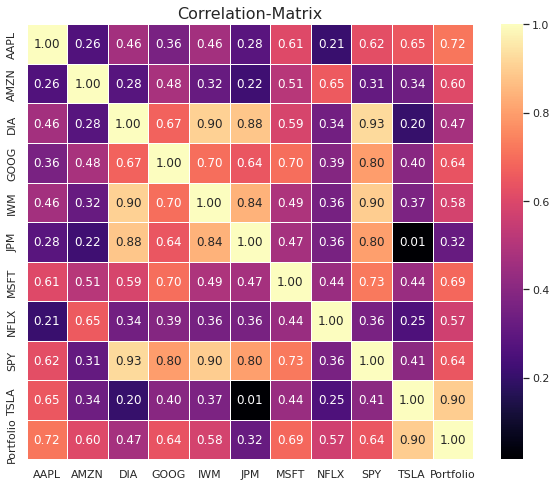

In [32]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap="magma", linewidths=.7, fmt=".2f")
heatmap.set_title("Correlation-Matrix", fontsize=16)
plt.show()